<a href="https://colab.research.google.com/github/SidLuca/Event-Type-Classification/blob/main/event_clasiffication_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Initial shape: (70606, 61)
Event type counts:
 mc_label
bbbar    35765
ccbar    23333
uubar     8172
ddbar     1879
ssbar     1457
Name: count, dtype: int64
Final feature count after cleaning: 50
Train/Test shapes: (52954, 50) (17652, 50)
Estimating feature importances with RandomForest...
Top 12 features:
 ['R2', 'thrustOm', 'KSFWVariables__bohoo2__bc', 'thrust', 'cosTBTO', 'CleoConeCS__bo1__bc', 'foxWolframR2', 'KSFWVariables__bohso02__bc', 'KSFWVariables__bohso02__cmFS1__bc', 'thrustBm', 'KSFWVariables__bohso12__bc', 'KSFWVariables__bohso12__cmFS1__bc']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification report:
               precision    recall  f1-score   support

       bbbar       0.79      0.90      0.84      8942
       ccbar       0.61      0.71      0.65      5833
       ddbar       0.00      0.00      0.00       470
       ssbar       0.00      0.00      0.00       364
       uubar       0.41      0.12      0.19      2043

    accuracy                           0.70     17652
   macro avg       0.36      0.35      0.34     17652
weighted avg       0.65      0.70      0.66     17652

Confusion matrix:
 [[8008  899    0    0   35]
 [1457 4157    0    0  219]
 [ 124  294    0    0   52]
 [  90  230    0    0   44]
 [ 517 1281    0    0  245]]
PCA components for 95% variance: 7


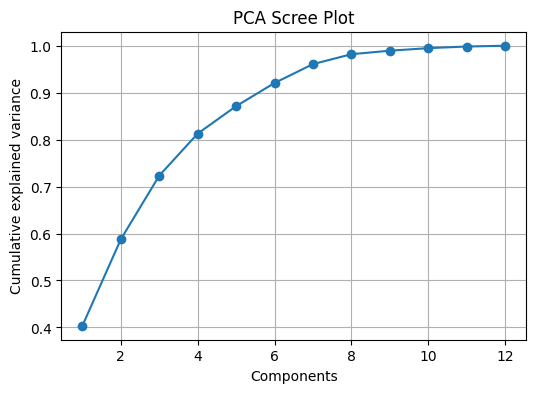

In [ ]:


import os, joblib
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# CONFIG
# --------------------------
CSV_PATH = "data_hep - data_hep.csv"
TOP_N_FEATURES = 12
RANDOM_STATE = 42

# --------------------------
# 1. Load data
# --------------------------
print("Loading dataset...")
df = pd.read_csv(CSV_PATH)
print("Initial shape:", df.shape)

# Drop bookkeeping column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type to labels
def map_type(t):
    if t in (0,1): return "bbbar"
    return {2:"ccbar", 3:"uubar", 4:"ddbar", 5:"ssbar"}.get(t, "other")

df["mc_label"] = df["type"].map(map_type)
print("Event type counts:\n", df["mc_label"].value_counts())

# --------------------------
# 2. Clean features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constant features
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [c for c in features if c not in const_cols]

# Drop very low variance features
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# Correlation pruning
corr = df[features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.98)]
df = df.drop(columns=to_drop)
features = [f for f in features if f not in to_drop]

print("Final feature count after cleaning:", len(features))

# --------------------------
# 3. Prepare data
# --------------------------
X = df[features].fillna(0).values
y = df["mc_label"].values
le = LabelEncoder()
y_enc = le.fit_transform(y)

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=RANDOM_STATE
)
print("Train/Test shapes:", Xtr.shape, Xte.shape)

# --------------------------
# 4. Feature importance (RandomForest)
# --------------------------
print("Estimating feature importances with RandomForest...")
rf = RandomForestClassifier(
    n_estimators=150, max_depth=7, random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(Xtr, ytr)

feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
topN = feat_imp.head(TOP_N_FEATURES).index.tolist()
print(f"Top {TOP_N_FEATURES} features:\n", topN)

# --------------------------
# 5. Train reduced model (Logistic Regression)
# --------------------------
Xtr_red = Xtr[:, [features.index(f) for f in topN]]
Xte_red = Xte[:, [features.index(f) for f in topN]]

scaler = StandardScaler().fit(Xtr_red)
Xtr_red_s = scaler.transform(Xtr_red)
Xte_red_s = scaler.transform(Xte_red)

lr = LogisticRegression(
    max_iter=500, multi_class="multinomial", solver="saga", random_state=RANDOM_STATE, n_jobs=-1
)
lr.fit(Xtr_red_s, ytr)

ypred = lr.predict(Xte_red_s)

print("\nClassification report:\n", classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(yte, ypred))

# --------------------------
# 6. PCA on reduced features
# --------------------------
pca = PCA().fit(Xtr_red_s)
cumvar = np.cumsum(pca.explained_variance_ratio_)
n95 = int(np.searchsorted(cumvar, 0.95) + 1)
print("PCA components for 95% variance:", n95)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()


Binary_classification

Event counts:
 binary_label
BB           35765
continuum    34841
Name: count, dtype: int64
Final features: 50
Top 12 features: ['R2', 'thrustOm', 'thrust', 'KSFWVariables__bohoo2__bc', 'cosTBTO', 'foxWolframR2', 'KSFWVariables__bohso02__bc', 'thrustBm', 'KSFWVariables__bohso02__cmFS1__bc', 'CleoConeCS__bo1__bc', 'KSFWVariables__bohso12__bc', 'KSFWVariables__bohso12__cmFS1__bc']

Classification Report:
               precision    recall  f1-score   support

          BB       0.82      0.85      0.83      8942
   continuum       0.84      0.80      0.82      8710

    accuracy                           0.83     17652
   macro avg       0.83      0.83      0.83     17652
weighted avg       0.83      0.83      0.83     17652

Confusion Matrix:
 [[7621 1321]
 [1707 7003]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


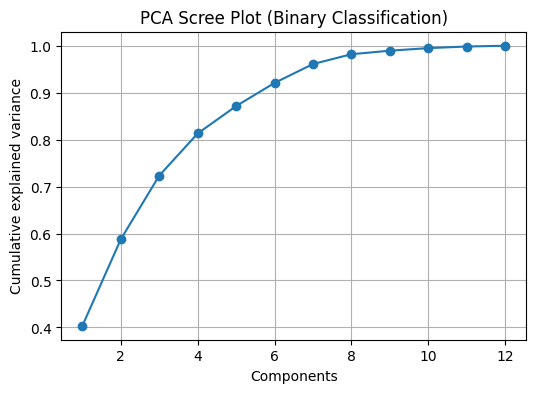

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

# Drop bookkeeping col
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type -> binary class
def map_binary(t):
    if t in (0,1): return "BB"
    else: return "continuum"

df["binary_label"] = df["type"].map(map_binary)

print("Event counts:\n", df["binary_label"].value_counts())

# --------------------------
# Clean features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [c for c in features if c not in const_cols]

# Drop low variance
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# Correlation pruning
corr = df[features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.98)]
df = df.drop(columns=to_drop)
features = [f for f in features if f not in to_drop]

print("Final features:", len(features))

# --------------------------
# Prepare data
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# --------------------------
# Feature importance
# --------------------------
rf = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)

feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
topN = feat_imp.head(12).index.tolist()
print("Top 12 features:", topN)

# --------------------------
# Train reduced Logistic Regression
# --------------------------
Xtr_red = Xtr[:, [features.index(f) for f in topN]]
Xte_red = Xte[:, [features.index(f) for f in topN]]

scaler = StandardScaler().fit(Xtr_red)
Xtr_red_s = scaler.transform(Xtr_red)
Xte_red_s = scaler.transform(Xte_red)

lr = LogisticRegression(max_iter=500, solver="saga", random_state=42)
lr.fit(Xtr_red_s, ytr)

ypred = lr.predict(Xte_red_s)

print("\nClassification Report:\n", classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred))

# --------------------------
# PCA Scree Plot
# --------------------------
pca = PCA().fit(Xtr_red_s)
cumvar = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot (Binary Classification)")
plt.grid(True)
plt.show()


Same with others

Event counts:
 binary_label
BB           35765
continuum    34841
Name: count, dtype: int64

=== Random Forest ===
              precision    recall  f1-score   support

          BB       0.85      0.88      0.86      8942
   continuum       0.87      0.84      0.85      8710

    accuracy                           0.86     17652
   macro avg       0.86      0.86      0.86     17652
weighted avg       0.86      0.86      0.86     17652

Confusion Matrix:
 [[7840 1102]
 [1385 7325]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:14:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

          BB       0.88      0.90      0.89      8942
   continuum       0.89      0.87      0.88      8710

    accuracy                           0.88     17652
   macro avg       0.88      0.88      0.88     17652
weighted avg       0.88      0.88      0.88     17652

Confusion Matrix:
 [[8021  921]
 [1140 7570]]

Top 15 features from RF:
 R2                                   0.180411
thrustOm                             0.080225
KSFWVariables__bohoo2__bc            0.051144
KSFWVariables__bohoo2__cmFS1__bc     0.046634
thrust                               0.043895
cosTBTO                              0.041816
thrustBm                             0.041082
foxWolframR2                         0.035877
KSFWVariables__bohso02__bc           0.030666
CleoConeCS__bo1__bc                  0.026905
KSFWVariables__bohso02__cmFS1__bc    0.021973
KSFWVariables__bohso12__bc           0.021213
KSFWVariables__bohso12__cmFS1__

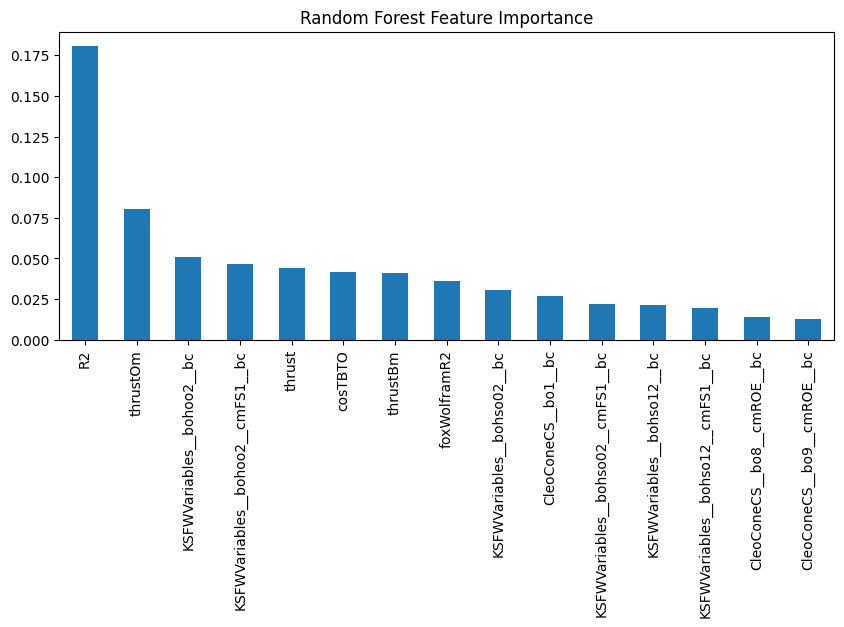

Top 15 XGBoost features:
 R2                                  0.417374
CleoConeCS__bo1__bc                 0.024587
thrustOm                            0.021853
CleoConeCS__bo1__cmROE__bc          0.021792
thrustBm                            0.021266
KSFWVariables__bohoo0__cmFS1__bc    0.020400
KSFWVariables__bohso20__bc          0.016594
KSFWVariables__bohoo0__bc           0.015780
KSFWVariables__bohso12__bc          0.014284
KSFWVariables__bomm2__bc            0.014094
CleoConeCS__bo2__bc                 0.013597
KSFWVariables__boet__bc             0.013417
KSFWVariables__bohso22__bc          0.013010
cosTBz                              0.012312
thrust                              0.011697
dtype: float32


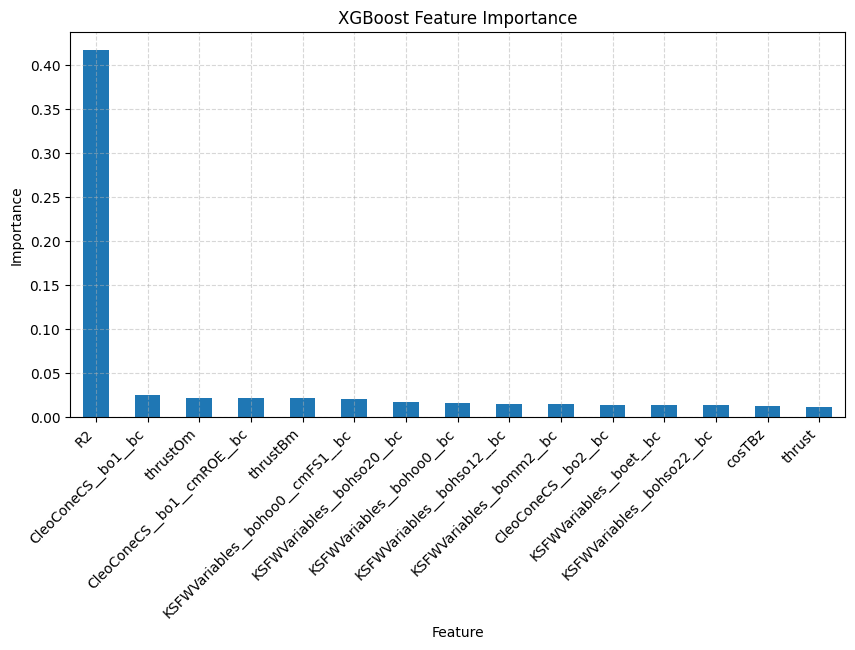

<Figure size 1000x600 with 0 Axes>

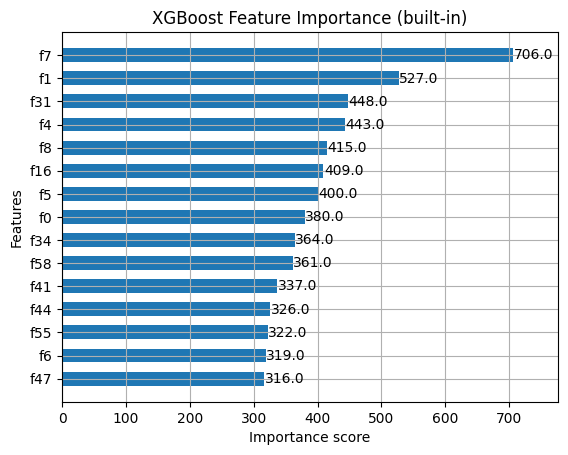

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

# Drop bookkeeping col
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type -> binary class
def map_binary(t):
    if t in (0,1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)
print("Event counts:\n", df["binary_label"].value_counts())

# --------------------------
# Prepare features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [f for f in features if f not in const_cols]

# Drop low variance
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# --------------------------
# Train/test split
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = BB, 1 = continuum

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# --------------------------
# Scale features
# --------------------------
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# --------------------------
# 1. Random Forest
# --------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,        # Let trees grow fully
    min_samples_leaf=5,    # Prevent overfitting
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr_s, ytr)
ypred_rf = rf.predict(Xte_s)

print("\n=== Random Forest ===")
print(classification_report(yte, ypred_rf, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred_rf))

# --------------------------
# 2. Gradient Boosting (XGBoost)
# --------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(Xtr_s, ytr)
ypred_xgb = xgb_model.predict(Xte_s)

print("\n=== XGBoost ===")
print(classification_report(yte, ypred_xgb, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred_xgb))

# --------------------------
# Optional: Feature importance from Random Forest
# --------------------------
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
top_features = importances.head(15)
print("\nTop 15 features from RF:\n", top_features)
top_features.plot(kind='bar', figsize=(10,4), title='Random Forest Feature Importance')
plt.show()
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# XGBoost feature importance
# --------------------------
xgb_importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

# Top 15 features
top_xgb = xgb_importances.head(15)
print("Top 15 XGBoost features:\n", top_xgb)

# Plot
plt.figure(figsize=(10,5))
top_xgb.plot(kind='bar', title='XGBoost Feature Importance')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Optional: XGBoost built-in plot
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=15, height=0.6)
plt.title("XGBoost Feature Importance (built-in)")
plt.show()



diffrents_models

Event counts:
 binary_label
BB           35765
continuum    34841
Name: count, dtype: int64

=== RandomForest ===
              precision    recall  f1-score   support

          BB       0.85      0.88      0.86      8942
   continuum       0.87      0.84      0.85      8710

    accuracy                           0.86     17652
   macro avg       0.86      0.86      0.86     17652
weighted avg       0.86      0.86      0.86     17652

Confusion Matrix:
 [[7840 1102]
 [1385 7325]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

          BB       0.88      0.90      0.89      8942
   continuum       0.89      0.87      0.88      8710

    accuracy                           0.88     17652
   macro avg       0.88      0.88      0.88     17652
weighted avg       0.88      0.88      0.88     17652

Confusion Matrix:
 [[8021  921]
 [1140 7570]]
[LightGBM] [Info] Number of positive: 26131, number of negative: 26823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 52954, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493466 -> initscore=-0.026137
[LightGBM] [Info] Start training from score -0.026137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LightGBM ===
              precision    recall  f1-score   support

          BB       0.87      0.90      0.88      8942
   continuum       0.89      0.87      0.88      8710

    accuracy                           0.88     17652
   macro avg       0.88      0.88      0.88     17652
weighted avg       0.88      0.88      0.88     17652

Confusion Matrix:
 [[8022  920]
 [1168 7542]]

Model comparison:
               accuracy  f1_score
RandomForest  0.859109  0.858989
XGBoost       0.883243  0.883166
LightGBM      0.881713  0.881626


<Figure size 600x400 with 0 Axes>

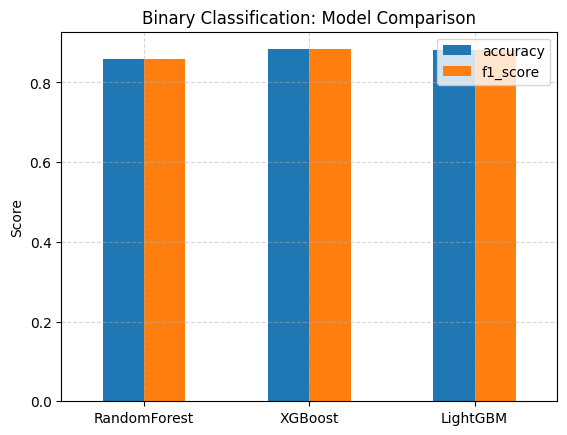

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Tree-based models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Binary mapping
def map_binary(t):
    if t in (0,1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)
print("Event counts:\n", df["binary_label"].value_counts())

# Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants and low variance
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [f for f in features if f not in const_cols]

variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# --------------------------
# Train/test split
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = BB, 1 = continuum

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# Scale features
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# --------------------------
# Models dictionary
# --------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=5, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                                 use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42)
}

# --------------------------
# Train, predict, evaluate
# --------------------------
results = {}

for name, model in models.items():
    model.fit(Xtr_s, ytr)
    ypred = model.predict(Xte_s)

    print(f"\n=== {name} ===")
    print(classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(yte, ypred))

    results[name] = {
        "accuracy": (ypred == yte).mean(),
        "f1_score": classification_report(yte, ypred, output_dict=True)["macro avg"]["f1-score"]
    }

# --------------------------
# Compare accuracies and F1
# --------------------------
results_df = pd.DataFrame(results).T
print("\nModel comparison:\n", results_df)

# Plot comparison
plt.figure(figsize=(6,4))
results_df[["accuracy","f1_score"]].plot(kind='bar', rot=0)
plt.title("Binary Classification: Model Comparison")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Event counts:
 binary_label
BB           35765
continuum    34841
Name: count, dtype: int64

Top 20 selected features:
 ['R2' 'thrustBm' 'thrustOm' 'cosTBTO' 'CleoConeCS__bo1__bc'
 'CleoConeCS__bo2__bc' 'CleoConeCS__bo7__bc' 'CleoConeCS__bo8__bc'
 'CleoConeCS__bo9__bc' 'CleoConeCS__bo2__cmROE__bc'
 'CleoConeCS__bo7__cmROE__bc' 'CleoConeCS__bo8__cmROE__bc'
 'CleoConeCS__bo9__cmROE__bc' 'KSFWVariables__bohso02__bc'
 'KSFWVariables__bohso12__bc' 'KSFWVariables__bohso02__cmFS1__bc'
 'KSFWVariables__bohso12__cmFS1__bc' 'foxWolframR2' 'foxWolframR4'
 'thrust']

=== RandomForest ===
              precision    recall  f1-score   support

          BB       0.84      0.87      0.85      8942
   continuum       0.86      0.83      0.85      8710

    accuracy                           0.85     17652
   macro avg       0.85      0.85      0.85     17652
weighted avg       0.85      0.85      0.85     17652

Confusion Matrix:
 [[7772 1170]
 [1479 7231]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:23:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

          BB       0.85      0.87      0.86      8942
   continuum       0.87      0.84      0.85      8710

    accuracy                           0.86     17652
   macro avg       0.86      0.86      0.86     17652
weighted avg       0.86      0.86      0.86     17652

Confusion Matrix:
 [[7804 1138]
 [1410 7300]]
[LightGBM] [Info] Number of positive: 26131, number of negative: 26823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 52954, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493466 -> initscore=-0.026137
[LightGBM] [Info] Start training from score -0.026137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LightGBM ===
              precision    recall  f1-score   support

          BB       0.85      0.87      0.86      8942
   continuum       0.87      0.84      0.85      8710

    accuracy                           0.86     17652
   macro avg       0.86      0.86      0.86     17652
weighted avg       0.86      0.86      0.86     17652

Confusion Matrix:
 [[7817 1125]
 [1425 7285]]


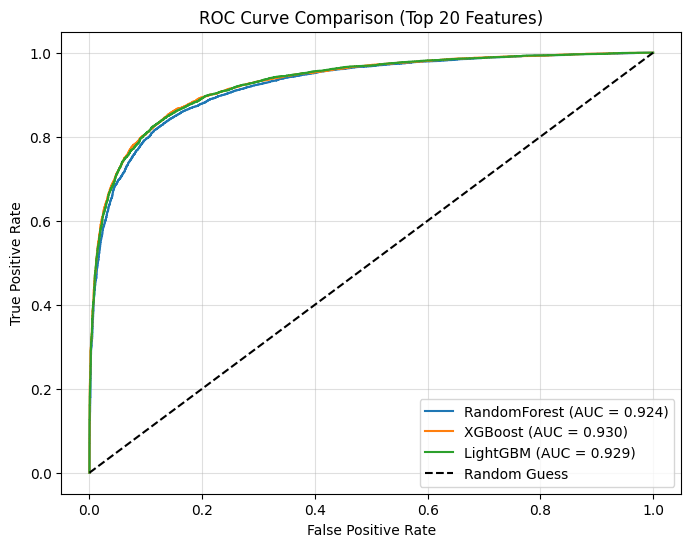


Model comparison:
               accuracy  f1_score   roc_auc
RandomForest  0.849932  0.849791  0.923618
XGBoost       0.855654  0.855536  0.929582
LightGBM      0.855540  0.855409  0.929210


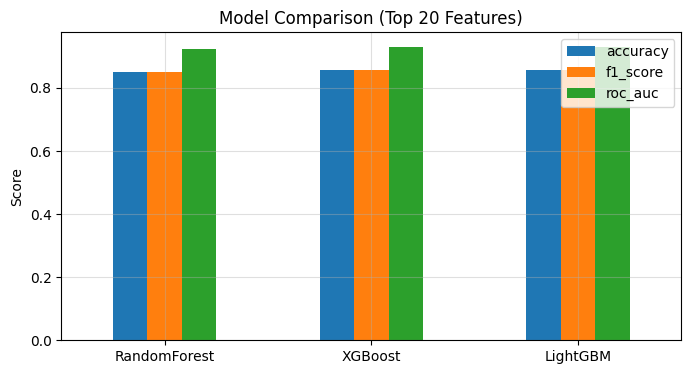

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import lightgbm as lgb

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Binary mapping
def map_binary(t):
    if t in (0, 1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)
print("Event counts:\n", df["binary_label"].value_counts())

# Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants and low variance
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [f for f in features if f not in const_cols]

variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# --------------------------
# Train/test split
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = BB, 1 = continuum

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# Scale features
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# --------------------------
# Feature selection (Select K Best)
# --------------------------
k = 20  # You can adjust this number based on dataset size
selector = SelectKBest(score_func=f_classif, k=k)
Xtr_k = selector.fit_transform(Xtr_s, ytr)
Xte_k = selector.transform(Xte_s)

selected_features = np.array(features)[selector.get_support()]
print(f"\nTop {k} selected features:\n", selected_features)

# --------------------------
# Models
# --------------------------
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300, min_samples_leaf=5, random_state=42, n_jobs=-1
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        use_label_encoder=False, eval_metric="logloss", random_state=42
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
}

# --------------------------
# Train, predict, evaluate, ROC
# --------------------------
results = {}
plt.figure(figsize=(8,6))

for name, model in models.items():
    model.fit(Xtr_k, ytr)
    ypred = model.predict(Xte_k)
    yprob = model.predict_proba(Xte_k)[:, 1]  # probability for class '1' (continuum)

    # Metrics
    cm = confusion_matrix(yte, ypred)
    print(f"\n=== {name} ===")
    print(classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
    print("Confusion Matrix:\n", cm)

    fpr, tpr, _ = roc_curve(yte, yprob)
    roc_auc = auc(fpr, tpr)

    results[name] = {
        "accuracy": (ypred == yte).mean(),
        "f1_score": classification_report(yte, ypred, output_dict=True)["macro avg"]["f1-score"],
        "roc_auc": roc_auc
    }

    # ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# --------------------------
# ROC Curve comparison
# --------------------------
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve Comparison (Top {k} Features)")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

# --------------------------
# Compare metrics
# --------------------------
results_df = pd.DataFrame(results).T
print("\nModel comparison:\n", results_df)

results_df[["accuracy", "f1_score", "roc_auc"]].plot(
    kind="bar", figsize=(8,4), rot=0, title=f"Model Comparison (Top {k} Features)"
)
plt.grid(alpha=0.4)
plt.ylabel("Score")
plt.show()


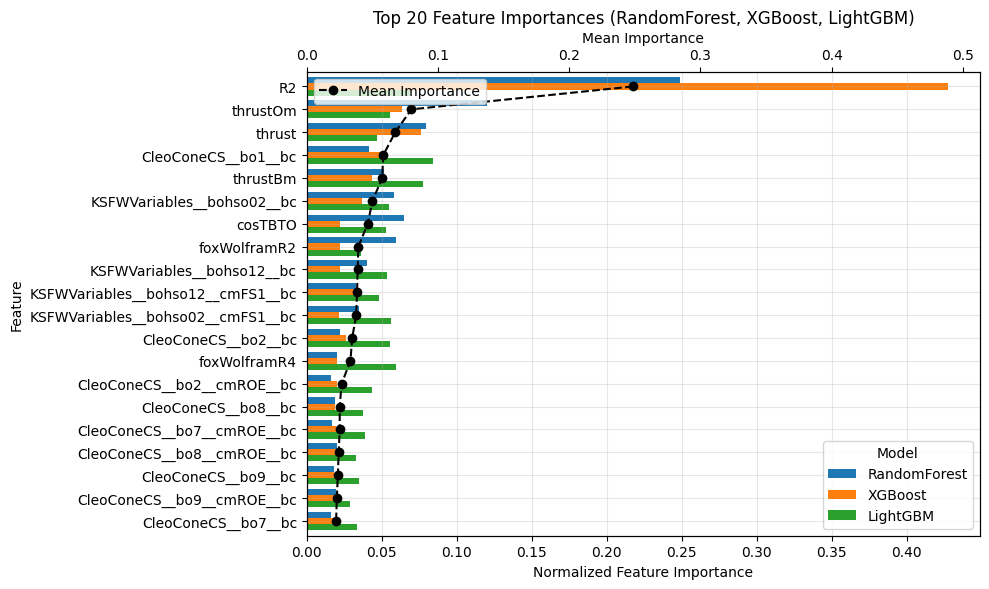


=== Top Features (averaged across models) ===
                                   mean_importance
R2                                        0.248431
thrustOm                                  0.079729
thrust                                    0.067463
CleoConeCS__bo1__bc                       0.058278
thrustBm                                  0.057485
KSFWVariables__bohso02__bc                0.050089
cosTBTO                                   0.046473
foxWolframR2                              0.039367
KSFWVariables__bohso12__bc                0.038768
KSFWVariables__bohso12__cmFS1__bc         0.038322
KSFWVariables__bohso02__cmFS1__bc         0.037688
CleoConeCS__bo2__bc                       0.034606
foxWolframR4                              0.033278
CleoConeCS__bo2__cmROE__bc                0.026554
CleoConeCS__bo8__bc                       0.025102
CleoConeCS__bo7__cmROE__bc                0.025097
CleoConeCS__bo8__cmROE__bc                0.024331
CleoConeCS__bo9__bc                

In [8]:
# --------------------------
# Compare Feature Importances Across Models (with mean overlay)
# --------------------------

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Collect feature importances for each model
feature_importances = {}

for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        feature_importances[name] = model.feature_importances_
    else:
        print(f"⚠️ {name} does not provide feature importances.")

# Combine into a single DataFrame
fi_df = pd.DataFrame(feature_importances, index=selected_features)

# Normalize each column (so sum = 1 per model)
fi_df = fi_df / fi_df.sum()

# Compute mean importance
fi_df["mean_importance"] = fi_df.mean(axis=1)

# Sort by average importance
fi_df = fi_df.sort_values("mean_importance", ascending=False)

# Select top N features
top_n = 20
top_features = fi_df.head(top_n)

# --------------------------
# Plot
# --------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for each model
top_features.drop(columns=["mean_importance"]).plot(
    kind="barh", ax=ax1, width=0.8
)
ax1.invert_yaxis()
ax1.set_xlabel("Normalized Feature Importance")
ax1.set_ylabel("Feature")
ax1.set_title(f"Top {top_n} Feature Importances (RandomForest, XGBoost, LightGBM)")
ax1.grid(alpha=0.3)
ax1.legend(title="Model", loc="lower right")

# Overlay mean importance line
ax2 = ax1.twiny()
ax2.plot(
    top_features["mean_importance"],
    np.arange(len(top_features)),
    "k--o",
    label="Mean Importance"
)
ax2.set_xlim(0, top_features.drop(columns=["mean_importance"]).values.max() * 1.2)
ax2.set_xlabel("Mean Importance")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

# Print top features
print("\n=== Top Features (averaged across models) ===")
print(top_features[["mean_importance"]])


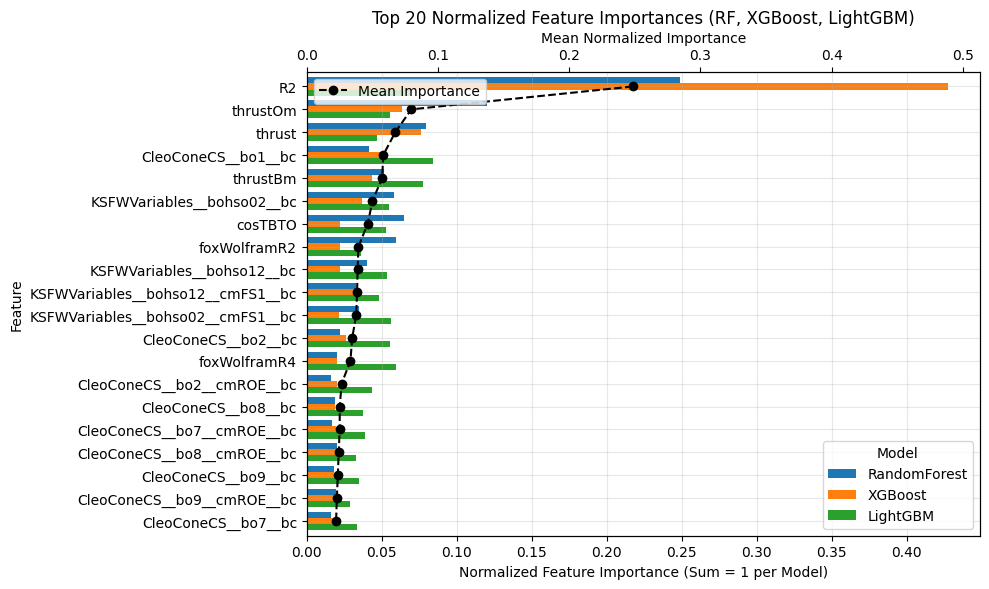


=== Top Normalized Feature Importances (averaged across models) ===
 1. R2                              Mean Importance = 0.2484
 2. thrustOm                        Mean Importance = 0.0797
 3. thrust                          Mean Importance = 0.0675
 4. CleoConeCS__bo1__bc             Mean Importance = 0.0583
 5. thrustBm                        Mean Importance = 0.0575
 6. KSFWVariables__bohso02__bc      Mean Importance = 0.0501
 7. cosTBTO                         Mean Importance = 0.0465
 8. foxWolframR2                    Mean Importance = 0.0394
 9. KSFWVariables__bohso12__bc      Mean Importance = 0.0388
10. KSFWVariables__bohso12__cmFS1__bc  Mean Importance = 0.0383
11. KSFWVariables__bohso02__cmFS1__bc  Mean Importance = 0.0377
12. CleoConeCS__bo2__bc             Mean Importance = 0.0346
13. foxWolframR4                    Mean Importance = 0.0333
14. CleoConeCS__bo2__cmROE__bc      Mean Importance = 0.0266
15. CleoConeCS__bo8__bc             Mean Importance = 0.0251
16. CleoCo

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Collect feature importances for all models
# --------------------------
feature_importances = {}

for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        feature_importances[name] = model.feature_importances_
    else:
        print(f"⚠️ {name} does not provide feature importances.")

# Combine into a single DataFrame
fi_df = pd.DataFrame(feature_importances, index=selected_features)

# --------------------------
# Normalize each model's feature importance (so they sum to 1)
# --------------------------
fi_df = fi_df / fi_df.sum()

# Add mean importance column
fi_df["mean_importance"] = fi_df.mean(axis=1)

# Sort by mean importance (descending)
fi_df = fi_df.sort_values("mean_importance", ascending=False)

# Select top N features
top_n = 20
top_features = fi_df.head(top_n)

# --------------------------
# Plot normalized importances
# --------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot barh for each model
top_features.drop(columns=["mean_importance"]).plot(
    kind="barh", ax=ax1, width=0.8
)
ax1.invert_yaxis()
ax1.set_xlabel("Normalized Feature Importance (Sum = 1 per Model)")
ax1.set_ylabel("Feature")
ax1.set_title(f"Top {top_n} Normalized Feature Importances (RF, XGBoost, LightGBM)")
ax1.grid(alpha=0.3)
ax1.legend(title="Model", loc="lower right")

# Add mean importance overlay line
ax2 = ax1.twiny()
ax2.plot(
    top_features["mean_importance"],
    np.arange(len(top_features)),
    "k--o",
    label="Mean Importance"
)
ax2.set_xlim(0, top_features.drop(columns=["mean_importance"]).values.max() * 1.2)
ax2.set_xlabel("Mean Normalized Importance")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

# --------------------------
# Print ranked normalized importances
# --------------------------
print("\n=== Top Normalized Feature Importances (averaged across models) ===")
for i, (feature, row) in enumerate(top_features.iterrows(), start=1):
    print(f"{i:2d}. {feature:30s}  Mean Importance = {row['mean_importance']:.4f}")


In [11]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00


In [12]:
import catboost
print("CatBoost version:", catboost.__version__)


CatBoost version: 1.2.8


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['BB' 'continuum']

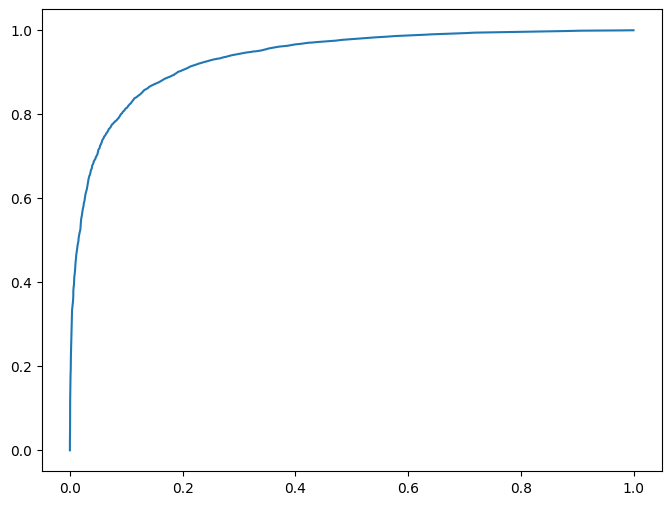

In [16]:
# -----------------------------
# Import all libraries
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("data_hep - data_hep.csv")  # adjust filename if needed

# Drop index column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# -----------------------------
# Create binary target
# -----------------------------
def map_binary(t):
    if t in (0, 1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)

# -----------------------------
# Prepare features and labels
# -----------------------------
X = df.drop(columns=["type", "binary_label"])
y = df["binary_label"]

# -----------------------------
# Split data
# -----------------------------
Xtr_k, Xte_k, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# -----------------------------
# Define models
# -----------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, random_seed=42, verbose=0)
}

# -----------------------------
# Train models and plot ROC curves
# -----------------------------
plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(Xtr_k, ytr)
    yprob = model.predict_proba(Xte_k)[:, 1]
    fpr, tpr, _ = roc_curve(yte.map({'BB': 0, 'continuum': 1}), yprob)
    auc = roc_auc_score(yte.map({'BB': 0, 'continuum': 1}), yprob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# -----------------------------
# ROC Plot
# -----------------------------
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 24389, number of negative: 25035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 49424, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493465 -> initscore=-0.026143
[LightGBM] [Info] Start training from score -0.026143


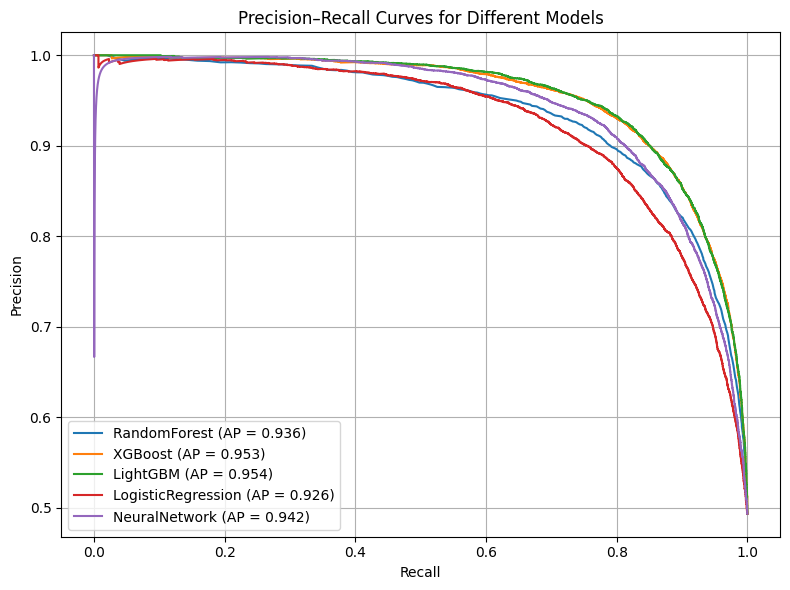

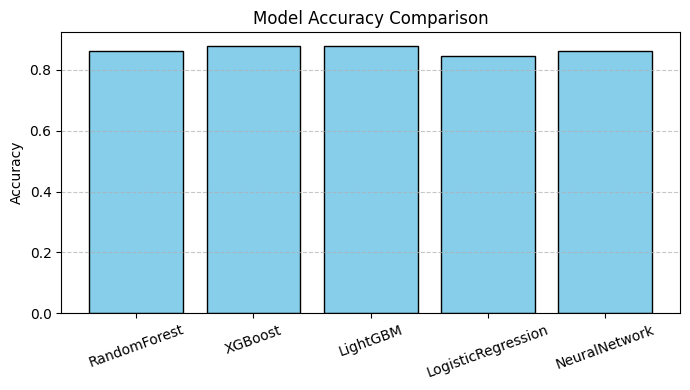


=== Model Performance Summary ===
                   RandomForest   XGBoost  LightGBM  LogisticRegression  \
Accuracy               0.861722  0.879898  0.879804            0.844821   
Average Precision      0.935636  0.953255  0.954140            0.925632   

                   NeuralNetwork  
Accuracy                0.862761  
Average Precision       0.941648  


In [17]:
# -----------------------------
# Import all libraries
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("data_hep - data_hep.csv")

# Drop unwanted column
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# -----------------------------
# Create binary target
# -----------------------------
def map_binary(t):
    if t in (0, 1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)

# -----------------------------
# Features and Labels
# -----------------------------
X = df.drop(columns=["type", "binary_label"])
y = df["binary_label"].map({"BB": 0, "continuum": 1})  # numeric

# Split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardize for models like Logistic Regression and Neural Network
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

# -----------------------------
# Define models
# -----------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, eval_metric='logloss', random_state=42, use_label_encoder=False),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
}

# -----------------------------
# Train, predict, evaluate
# -----------------------------
plt.figure(figsize=(8, 6))
accuracies = {}
avg_precisions = {}

for name, model in models.items():
    if name in ["LogisticRegression", "NeuralNetwork"]:
        model.fit(Xtr_s, ytr)
        yprob = model.predict_proba(Xte_s)[:, 1]
    else:
        model.fit(Xtr, ytr)
        yprob = model.predict_proba(Xte)[:, 1]

    ypred = (yprob > 0.5).astype(int)
    acc = accuracy_score(yte, ypred)
    accuracies[name] = acc

    precision, recall, _ = precision_recall_curve(yte, yprob)
    avg_prec = average_precision_score(yte, yprob)
    avg_precisions[name] = avg_prec

    plt.plot(recall, precision, label=f"{name} (AP = {avg_prec:.3f})")

# -----------------------------
# Plot Precision–Recall curves
# -----------------------------
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves for Different Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Accuracy Comparison
# -----------------------------
plt.figure(figsize=(7, 4))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue', edgecolor='k')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print summary table
results_df = pd.DataFrame({
    "Accuracy": accuracies,
    "Average Precision": avg_precisions
}).T
print("\n=== Model Performance Summary ===")
print(results_df)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:09:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 24389, number of negative: 25035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 49424, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493465 -> initscore=-0.026143
[LightGBM] [Info] Start training from score -0.026143


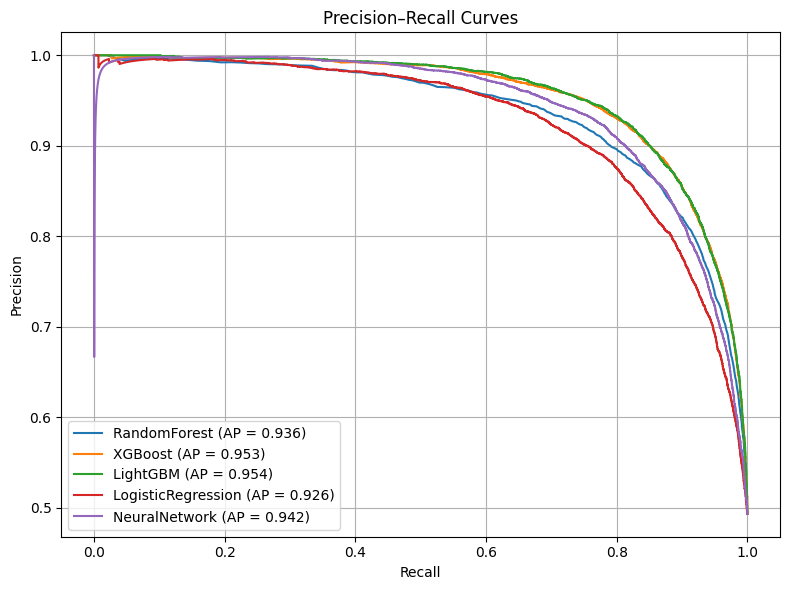

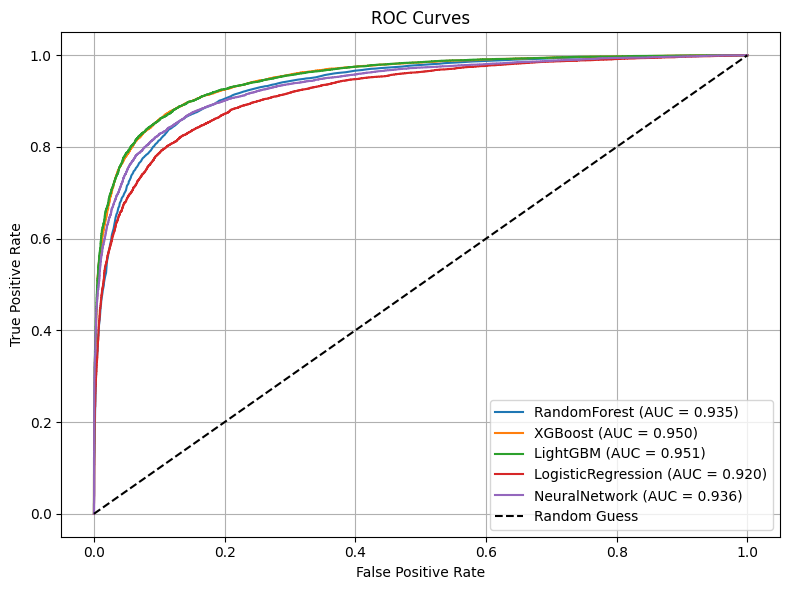

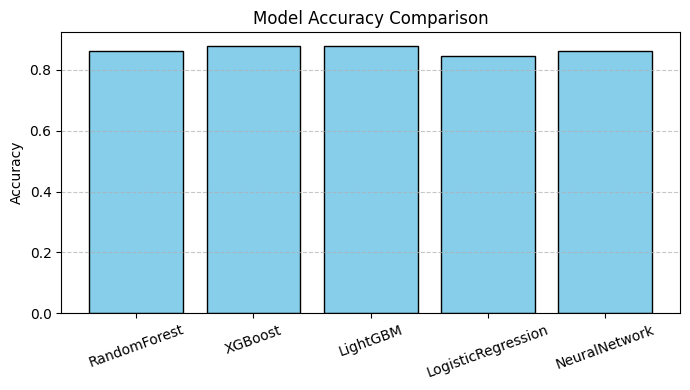


=== Model Performance Summary ===
                   RandomForest   XGBoost  LightGBM  LogisticRegression  \
Accuracy               0.861722  0.879898  0.879804            0.844821   
Average Precision      0.935636  0.953255  0.954140            0.925632   
ROC-AUC                0.935104  0.950334  0.950785            0.919909   

                   NeuralNetwork  
Accuracy                0.862761  
Average Precision       0.941648  
ROC-AUC                 0.935909  


In [18]:
# -----------------------------
# Import libraries
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("data_hep - data_hep.csv")

# Drop unwanted column
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# -----------------------------
# Create binary target
# -----------------------------
def map_binary(t):
    if t in (0, 1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)

# -----------------------------
# Features and Labels
# -----------------------------
X = df.drop(columns=["type", "binary_label"])
y = df["binary_label"].map({"BB": 0, "continuum": 1})  # numeric

# Split data
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardize features for Logistic Regression and Neural Network
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

# -----------------------------
# Define models
# -----------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, eval_metric='logloss', random_state=42, use_label_encoder=False),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
}

# -----------------------------
# Train models, collect metrics
# -----------------------------
accuracies = {}
avg_precisions = {}
roc_aucs = {}

plt.figure(figsize=(8, 6))
for name, model in models.items():
    # Standardize for LR/NN
    if name in ["LogisticRegression", "NeuralNetwork"]:
        model.fit(Xtr_s, ytr)
        yprob = model.predict_proba(Xte_s)[:, 1]
    else:
        model.fit(Xtr, ytr)
        yprob = model.predict_proba(Xte)[:, 1]

    ypred = (yprob > 0.5).astype(int)
    accuracies[name] = accuracy_score(yte, ypred)

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(yte, yprob)
    avg_precisions[name] = average_precision_score(yte, yprob)
    plt.plot(recall, precision, label=f"{name} (AP = {avg_precisions[name]:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# ROC Curves
# -----------------------------
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if name in ["LogisticRegression", "NeuralNetwork"]:
        yprob = model.predict_proba(Xte_s)[:, 1]
    else:
        yprob = model.predict_proba(Xte)[:, 1]

    fpr, tpr, _ = roc_curve(yte, yprob)
    roc_aucs[name] = roc_auc_score(yte, yprob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_aucs[name]:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Accuracy Comparison
# -----------------------------
plt.figure(figsize=(7, 4))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue', edgecolor='k')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -----------------------------
# Summary Table
# -----------------------------
results_df = pd.DataFrame({
    "Accuracy": accuracies,
    "Average Precision": avg_precisions,
    "ROC-AUC": roc_aucs
}).T
print("\n=== Model Performance Summary ===")
print(results_df)


Shape of data: (70606, 60)

Column names: ['R2', 'thrustBm', 'thrustOm', 'cosTBTO', 'cosTBz', 'KSFWVariables__boet__bc', 'KSFWVariables__bomm2__bc', 'CleoConeCS__bo1__bc', 'CleoConeCS__bo2__bc', 'CleoConeCS__bo3__bc', 'CleoConeCS__bo4__bc', 'CleoConeCS__bo5__bc', 'CleoConeCS__bo6__bc', 'CleoConeCS__bo7__bc', 'CleoConeCS__bo8__bc', 'CleoConeCS__bo9__bc', 'CleoConeCS__bo1__cmROE__bc', 'CleoConeCS__bo2__cmROE__bc', 'CleoConeCS__bo3__cmROE__bc', 'CleoConeCS__bo4__cmROE__bc', 'CleoConeCS__bo5__cmROE__bc', 'CleoConeCS__bo6__cmROE__bc', 'CleoConeCS__bo7__cmROE__bc', 'CleoConeCS__bo8__cmROE__bc', 'CleoConeCS__bo9__cmROE__bc', 'KSFWVariables__bohso00__bc', 'KSFWVariables__bohso02__bc', 'KSFWVariables__bohso04__bc', 'KSFWVariables__bohso10__bc', 'KSFWVariables__bohso12__bc', 'KSFWVariables__bohso14__bc', 'KSFWVariables__bohso20__bc', 'KSFWVariables__bohso22__bc', 'KSFWVariables__bohso24__bc', 'KSFWVariables__bohoo0__bc', 'KSFWVariables__bohoo1__bc', 'KSFWVariables__bohoo2__bc', 'KSFWVariables__b

/tmp/ipython-input-1011229143.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="binary_label", data=df, palette="viridis")


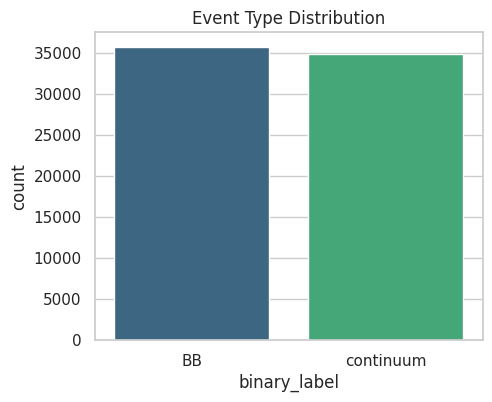


Summary Statistics:
                 R2      thrustBm      thrustOm       cosTBTO        cosTBz  \
count  70606.000000  70606.000000  70606.000000  70606.000000  70606.000000   
mean       0.270558      0.893022      0.736625      0.797588      0.596492   
std        0.153872      0.054866      0.083153      0.251321      0.291470   
min        0.005117      0.769393      0.539537      0.000009      0.000022   
25%        0.146839      0.846267      0.670867      0.716803      0.359924   
50%        0.240644      0.887268      0.729580      0.911825      0.652388   
75%        0.376046      0.935911      0.798976      0.974036      0.858216   
max        0.982304      0.999943      1.000000      1.000000      0.999993   

       KSFWVariables__boet__bc  KSFWVariables__bomm2__bc  CleoConeCS__bo1__bc  \
count             70606.000000              70606.000000         70606.000000   
mean                  7.180946                 -2.823599             1.702187   
std                   1.

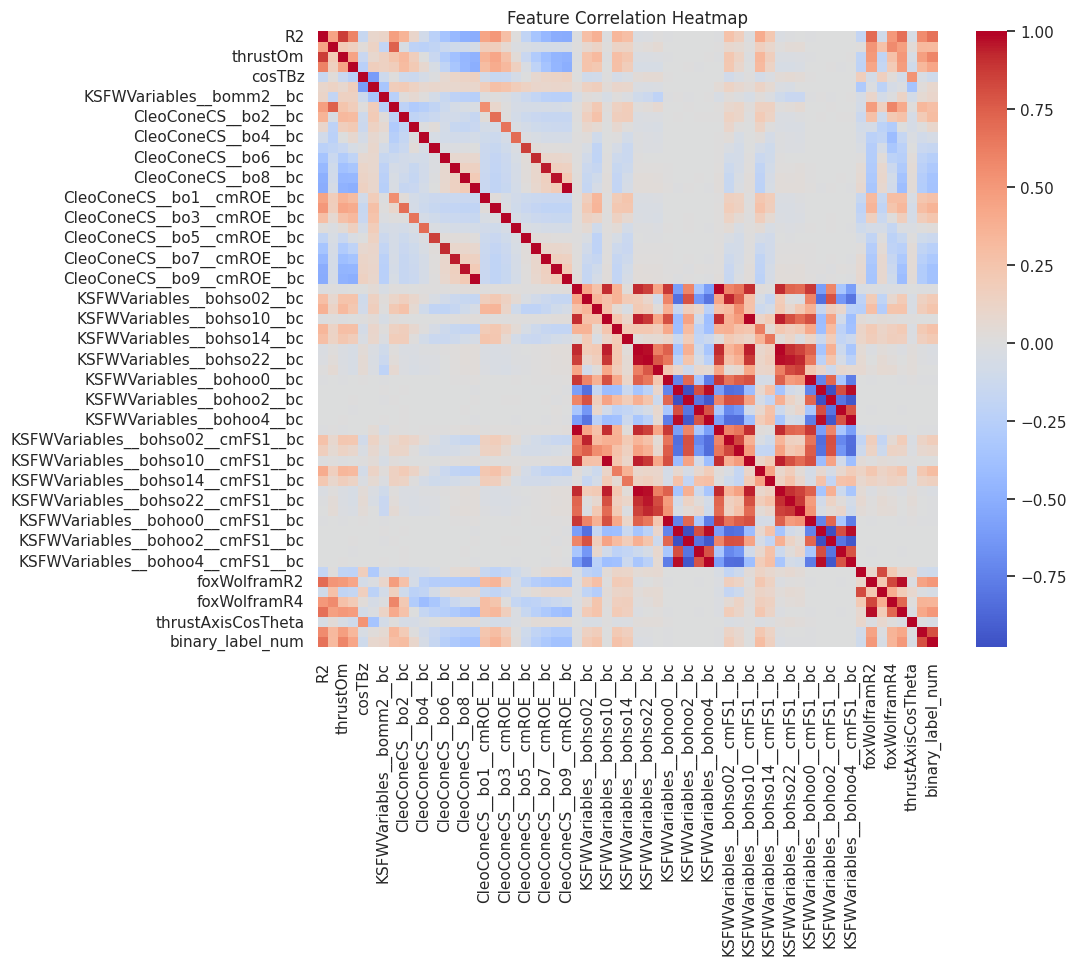

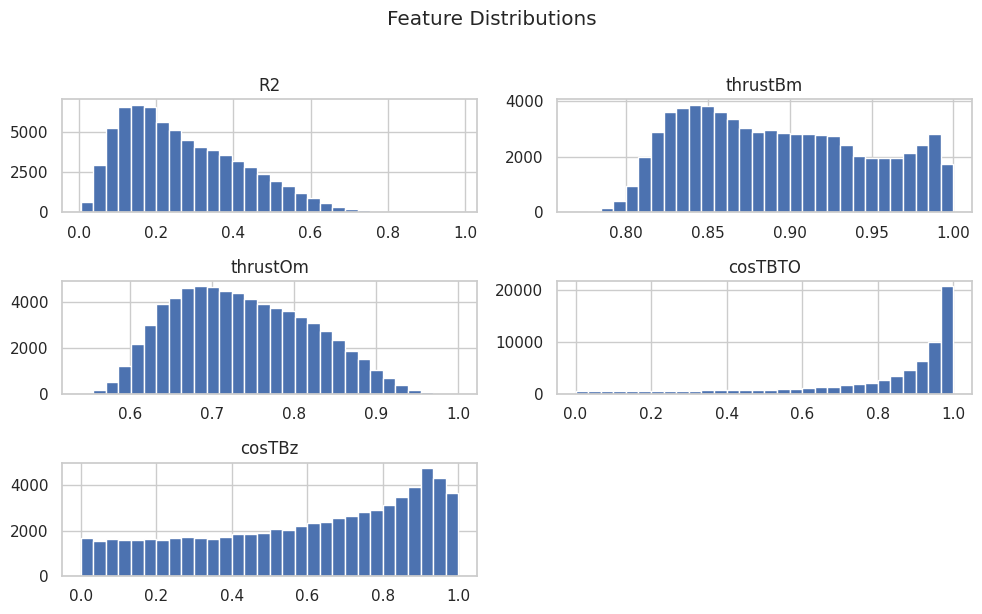

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:59:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Classification Report ===
              precision    recall  f1-score   support

          BB       0.87      0.90      0.88     10730
   continuum       0.89      0.87      0.88     10452

    accuracy                           0.88     21182
   macro avg       0.88      0.88      0.88     21182
weighted avg       0.88      0.88      0.88     21182



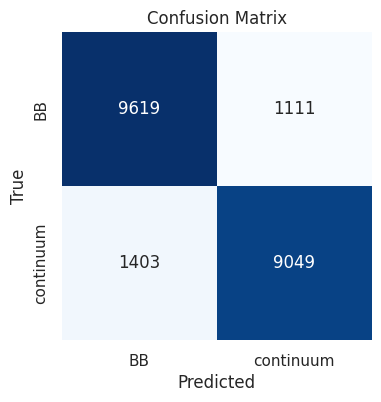

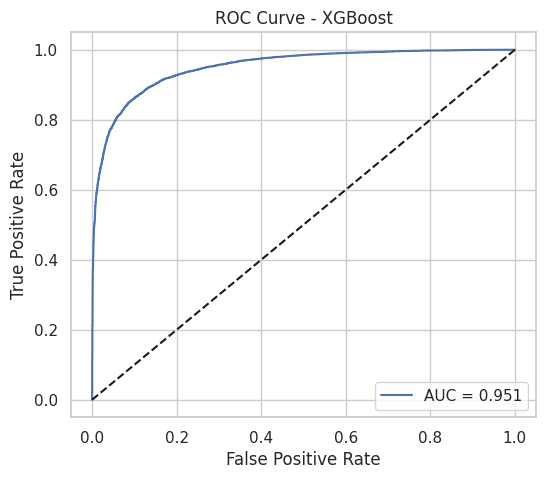

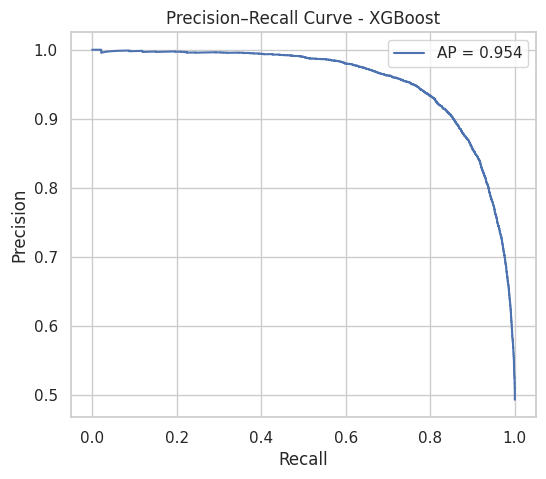

<Figure size 800x600 with 0 Axes>

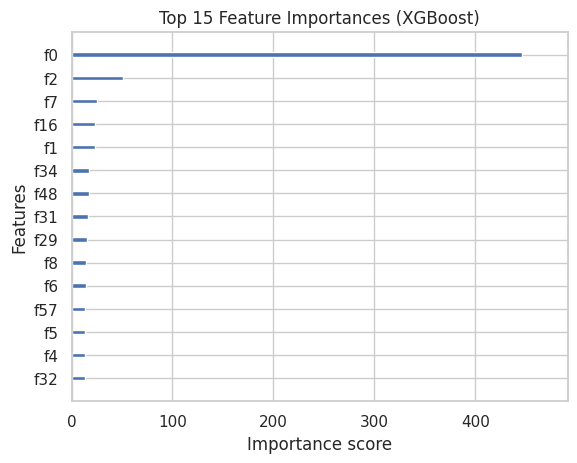


Top 15 Normalized Feature Importances:
                             Feature  Importance
0                                 R2    1.000000
2                           thrustOm    0.113740
7                CleoConeCS__bo1__bc    0.055513
16        CleoConeCS__bo1__cmROE__bc    0.053042
1                           thrustBm    0.051625
34         KSFWVariables__bohoo0__bc    0.039486
48  KSFWVariables__bohoo0__cmFS1__bc    0.037969
31        KSFWVariables__bohso20__bc    0.036724
29        KSFWVariables__bohso12__bc    0.034256
8                CleoConeCS__bo2__bc    0.031834
6           KSFWVariables__bomm2__bc    0.031736
57                            thrust    0.030945
5            KSFWVariables__boet__bc    0.029898
4                             cosTBz    0.029417
32        KSFWVariables__bohso22__bc    0.028962


In [19]:
# ==============================================
# 1. Import Required Libraries
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

from xgboost import XGBClassifier, plot_importance

sns.set(style="whitegrid", context="notebook")

# ==============================================
# 2. Load and Inspect Data
# ==============================================
df = pd.read_csv("data_hep - data_hep.csv")

# Drop bookkeeping columns
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

print("Shape of data:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nBasic Info:")
print(df.info())

# ==============================================
# 3. Create Binary Target
# ==============================================
def map_binary(t):
    if t in (0, 1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)
df["binary_label_num"] = df["binary_label"].map({"BB": 0, "continuum": 1})

print("\nEvent counts:")
print(df["binary_label"].value_counts())

# ==============================================
# 4. Exploratory Data Analysis
# ==============================================
# --- Distribution of classes
plt.figure(figsize=(5,4))
sns.countplot(x="binary_label", data=df, palette="viridis")
plt.title("Event Type Distribution")
plt.show()

# --- Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# --- Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- Example feature distributions
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
sample_features = numeric_cols[:5]  # first few features for visualization

df[sample_features].hist(figsize=(10, 6), bins=30)
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

# ==============================================
# 5. Preprocessing
# ==============================================
features = [c for c in df.columns if c not in ["type", "binary_label", "binary_label_num"]]
X = df[features]
y = df["binary_label_num"]

# Remove constant or low-variance features
low_var = X.var()[X.var() < 1e-8].index.tolist()
X = X.drop(columns=low_var)

# Split dataset
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Feature scaling (optional for XGBoost but good practice)
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

# ==============================================
# 6. Train XGBoost Model
# ==============================================
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

xgb_model.fit(Xtr_s, ytr)
ypred = xgb_model.predict(Xte_s)
yprob = xgb_model.predict_proba(Xte_s)[:, 1]

# ==============================================
# 7. Evaluation
# ==============================================
print("\n=== Classification Report ===")
print(classification_report(yte, ypred, target_names=["BB", "continuum"]))

# Confusion Matrix
cm = confusion_matrix(yte, ypred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["BB", "continuum"], yticklabels=["BB", "continuum"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(yte, yprob)
roc_auc = roc_auc_score(yte, yprob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(yte, yprob)
avg_prec = average_precision_score(yte, yprob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {avg_prec:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

# ==============================================
# 8. Feature Importance
# ==============================================
plt.figure(figsize=(8, 6))
plot_importance(xgb_model, max_num_features=15, importance_type="gain", show_values=False)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

# Normalize and display top features
importance = xgb_model.feature_importances_
importance_norm = importance / importance.max()
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importance_norm})
feat_imp = feat_imp.sort_values("Importance", ascending=False).head(15)

print("\nTop 15 Normalized Feature Importances:")
print(feat_imp)
